In [1]:
import os
import sys
import time
import random
import platform
import settings

import numpy as np
import nibabel as nib
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

from dataloader import z_score_normalize

plt.rcParams['font.family'] = settings.FONT_FAMILY
plt.rcParams['figure.dpi'] = 300
%matplotlib inline

print("Platform:              {}".format(platform.platform()))
print("Python version:        {}".format(sys.version))
print("TensorFlow version:    {}".format(tf.__version__))
gpu_status = "Available" if tf.config.list_physical_devices("GPU") else "Not Available"
color = "\033[92m" if gpu_status == "Available" else "\033[91m"
reset = "\033[0m"
print(f"GPU Status:            {color}{gpu_status}{reset}")

Platform:              macOS-15.1-arm64-arm-64bit
Python version:        3.10.8 (v3.10.8:aaaf517424, Oct 11 2022, 10:14:40) [Clang 13.0.0 (clang-1300.0.29.30)]
TensorFlow version:    2.15.0
GPU Status:            Available


In [2]:
training_data_path = settings.TRAIN_DATA_PATH
testing_data_path = settings.TEST_DATA_PATH

In [3]:
!tree -L 2 {training_data_path+'d'}

data/BraTS2021d
├── BraTS2021_00002
│   ├── BraTS2021_00002_flair.nii.gz
│   ├── BraTS2021_00002_seg.nii.gz
│   ├── BraTS2021_00002_t1.nii.gz
│   ├── BraTS2021_00002_t1ce.nii.gz
│   └── BraTS2021_00002_t2.nii.gz
└── BraTS2021_00005
    ├── BraTS2021_00005_flair.nii.gz
    ├── BraTS2021_00005_seg.nii.gz
    ├── BraTS2021_00005_t1.nii.gz
    ├── BraTS2021_00005_t1ce.nii.gz
    └── BraTS2021_00005_t2.nii.gz

3 directories, 10 files


In [4]:
!tree -L 2 {testing_data_path+'d'}

data/BraTS2017d
├── dataset.json
├── imagesTr
│   ├── BRATS_001.nii.gz
│   └── BRATS_002.nii.gz
└── labelsTr
    ├── BRATS_001.nii.gz
    └── BRATS_002.nii.gz

3 directories, 5 files


In [5]:
def get_data_dimensions(data_path):
    data_dimensions = set()
    for root, _, files in os.walk(os.path.join(data_path, 'imagesTr')):
        for file in files:
            if file.endswith(".nii.gz"):
                img = nib.load(os.path.join(root, file))
                data_dimensions.add(img.shape)
    return data_dimensions

In [6]:
print("Different data dimensions on training set:", get_data_dimensions(training_data_path))
print("Different data dimensions on test set:    ", get_data_dimensions(testing_data_path))

Different data dimensions on training set: {(240, 240, 155)}
Different data dimensions on test set:     {(240, 240, 155, 4)}


In [7]:
def examine_image(image_path):
    if image_path.endswith(".nii.gz"):
        img = nib.load(image_path)
        print(f"File: {image_path}, Shape: {img.shape}, Data Type: {img.get_data_dtype()}\n")
        data = img.get_fdata()
        print(f"Statistics: Min: {data.min()}, Max: {data.max()}, Mean: {data.mean()}, Std: {data.std()}\n")
    else:
        print("Invalid image path.")


def examine_label(label_path):
    if label_path.endswith(".nii.gz"):
        label_img = nib.load(label_path)
        print(f"File: {label_path}, Shape: {label_img.shape}, Data Type: {label_img.get_data_dtype()}\n")
        label_data = label_img.get_fdata()
        print(f"Distinct Cell Values: {np.unique(label_data)}\n")
    else:
        print("Invalid label path.")


def get_random_image_path(data_path):
    image_paths = []
    for root, _, files in os.walk(data_path):
        for file in files:
            if file.endswith(".nii.gz"):
                image_paths.append(os.path.join(root, file))
    if image_paths:
        return random.choice(image_paths)
    return None

In [8]:
for _ in range(5):
    examine_image(get_random_image_path(os.path.join(training_data_path, 'imagesTr')))

File: data/BraTS2021/imagesTr/BraTS2021_00378.nii.gz, Shape: (240, 240, 155), Data Type: int16

Statistics: Min: 0.0, Max: 784.0, Mean: 27.037970430107528, Std: 62.22273542497247

File: data/BraTS2021/imagesTr/BraTS2021_00183.nii.gz, Shape: (240, 240, 155), Data Type: int16

Statistics: Min: 0.0, Max: 1422.0, Mean: 35.32054849910394, Std: 96.69100398065997

File: data/BraTS2021/imagesTr/BraTS2021_01532.nii.gz, Shape: (240, 240, 155), Data Type: int16

Statistics: Min: 0.0, Max: 1072.0, Mean: 89.97697703853046, Std: 181.2426650606598

File: data/BraTS2021/imagesTr/BraTS2021_01395.nii.gz, Shape: (240, 240, 155), Data Type: int16

Statistics: Min: 0.0, Max: 309.0, Mean: 15.416393033154122, Std: 36.61458447347755

File: data/BraTS2021/imagesTr/BraTS2021_01127.nii.gz, Shape: (240, 240, 155), Data Type: int16

Statistics: Min: 0.0, Max: 1309.0, Mean: 29.49809397401434, Std: 78.58699452808177



In [9]:
for _ in range(5):
    examine_label(get_random_image_path(os.path.join(training_data_path, 'labelsTr')))

File: data/BraTS2021/labelsTr/BraTS2021_01055.nii.gz, Shape: (240, 240, 155), Data Type: uint16

Distinct Cell Values: [0. 1. 2. 4.]

File: data/BraTS2021/labelsTr/BraTS2021_01665.nii.gz, Shape: (240, 240, 155), Data Type: uint8

Distinct Cell Values: [0. 1. 2. 4.]

File: data/BraTS2021/labelsTr/BraTS2021_00403.nii.gz, Shape: (240, 240, 155), Data Type: uint16

Distinct Cell Values: [0. 1. 2. 4.]

File: data/BraTS2021/labelsTr/BraTS2021_01371.nii.gz, Shape: (240, 240, 155), Data Type: uint16

Distinct Cell Values: [0. 1. 2. 4.]

File: data/BraTS2021/labelsTr/BraTS2021_00380.nii.gz, Shape: (240, 240, 155), Data Type: uint16

Distinct Cell Values: [0. 2. 4.]



In [10]:
for _ in range(5):
    examine_image(get_random_image_path(os.path.join(testing_data_path, 'imagesTr')))

File: data/BraTS2017/imagesTr/BRATS_457.nii.gz, Shape: (240, 240, 155, 4), Data Type: float32

Statistics: Min: 0.0, Max: 1260.0, Mean: 60.195471102150535, Std: 149.7429390411196

File: data/BraTS2017/imagesTr/BRATS_329.nii.gz, Shape: (240, 240, 155, 4), Data Type: float32

Statistics: Min: 0.0, Max: 2505.0, Mean: 67.391736531138, Std: 178.89415653272317

File: data/BraTS2017/imagesTr/BRATS_218.nii.gz, Shape: (240, 240, 155, 4), Data Type: float32

Statistics: Min: 0.0, Max: 2476.0, Mean: 115.68921925403225, Std: 268.29496017541953

File: data/BraTS2017/imagesTr/BRATS_157.nii.gz, Shape: (240, 240, 155, 4), Data Type: float32

Statistics: Min: 0.0, Max: 2373.0, Mean: 104.54540809811827, Std: 246.75011281091204

File: data/BraTS2017/imagesTr/BRATS_308.nii.gz, Shape: (240, 240, 155, 4), Data Type: float32

Statistics: Min: 0.0, Max: 1674.0, Mean: 56.73152727374552, Std: 131.64160967068565



In [11]:
for _ in range(5):
    examine_label(get_random_image_path(os.path.join(testing_data_path, 'labelsTr')))

File: data/BraTS2017/labelsTr/BRATS_188.nii.gz, Shape: (240, 240, 155), Data Type: uint8

Distinct Cell Values: [0. 1. 2. 3.]

File: data/BraTS2017/labelsTr/BRATS_323.nii.gz, Shape: (240, 240, 155), Data Type: uint8

Distinct Cell Values: [0. 1. 2. 3.]

File: data/BraTS2017/labelsTr/BRATS_175.nii.gz, Shape: (240, 240, 155), Data Type: uint8

Distinct Cell Values: [0. 1. 2.]

File: data/BraTS2017/labelsTr/BRATS_316.nii.gz, Shape: (240, 240, 155), Data Type: uint8

Distinct Cell Values: [0. 1. 2. 3.]

File: data/BraTS2017/labelsTr/BRATS_094.nii.gz, Shape: (240, 240, 155), Data Type: uint8

Distinct Cell Values: [0. 1. 2. 3.]



In [12]:
def plot_largest_tumor_area(image_path):
    if not image_path.endswith(".nii.gz"):
        print("Invalid image path.")
        return

    img = nib.load(image_path)
    data = img.get_fdata()

    slice_index = np.argmax([np.sum(data[..., i]) for i in range(data.shape[-1])])

    label_path = image_path.replace('imagesTr', 'labelsTr')
    label_img = nib.load(label_path)
    label_data = label_img.get_fdata()

    combined_label = np.where(label_data != 0, 1, 0)
    file_name = os.path.basename(image_path).split('.')[0]

    normalized_data = z_score_normalize(data)

    plt.figure(figsize=(20, 10))

    def plot_subplot(data, index, title, subplot_index):
        plt.subplot(1, 4, subplot_index)
        plt.imshow(data[..., index], cmap="gray")
        plt.axis("off")
        plt.title(title, fontsize=16)

    plot_subplot(data, slice_index, f"MRI {file_name}", 1)
    plot_subplot(normalized_data, slice_index, "Z-score normalized", 2)
    plot_subplot(label_data, slice_index, "Label", 3)
    plot_subplot(combined_label, slice_index, "Combined label", 4)

    plt.tight_layout()
    plt.show()

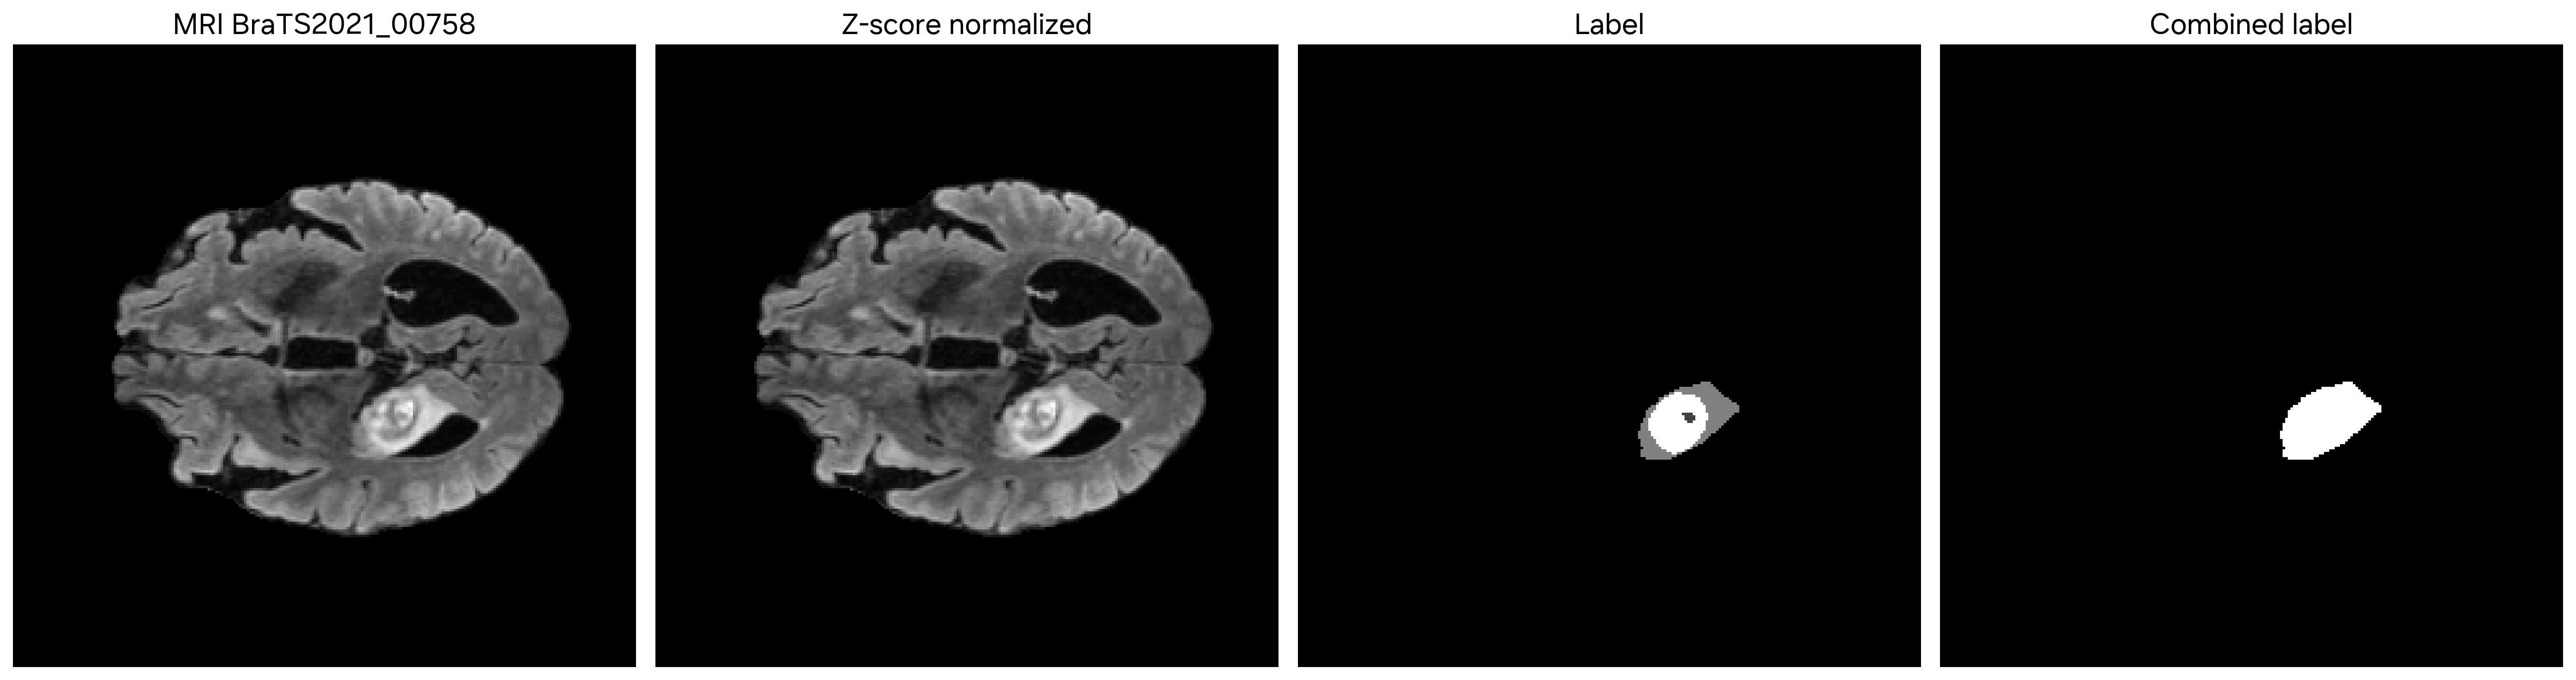

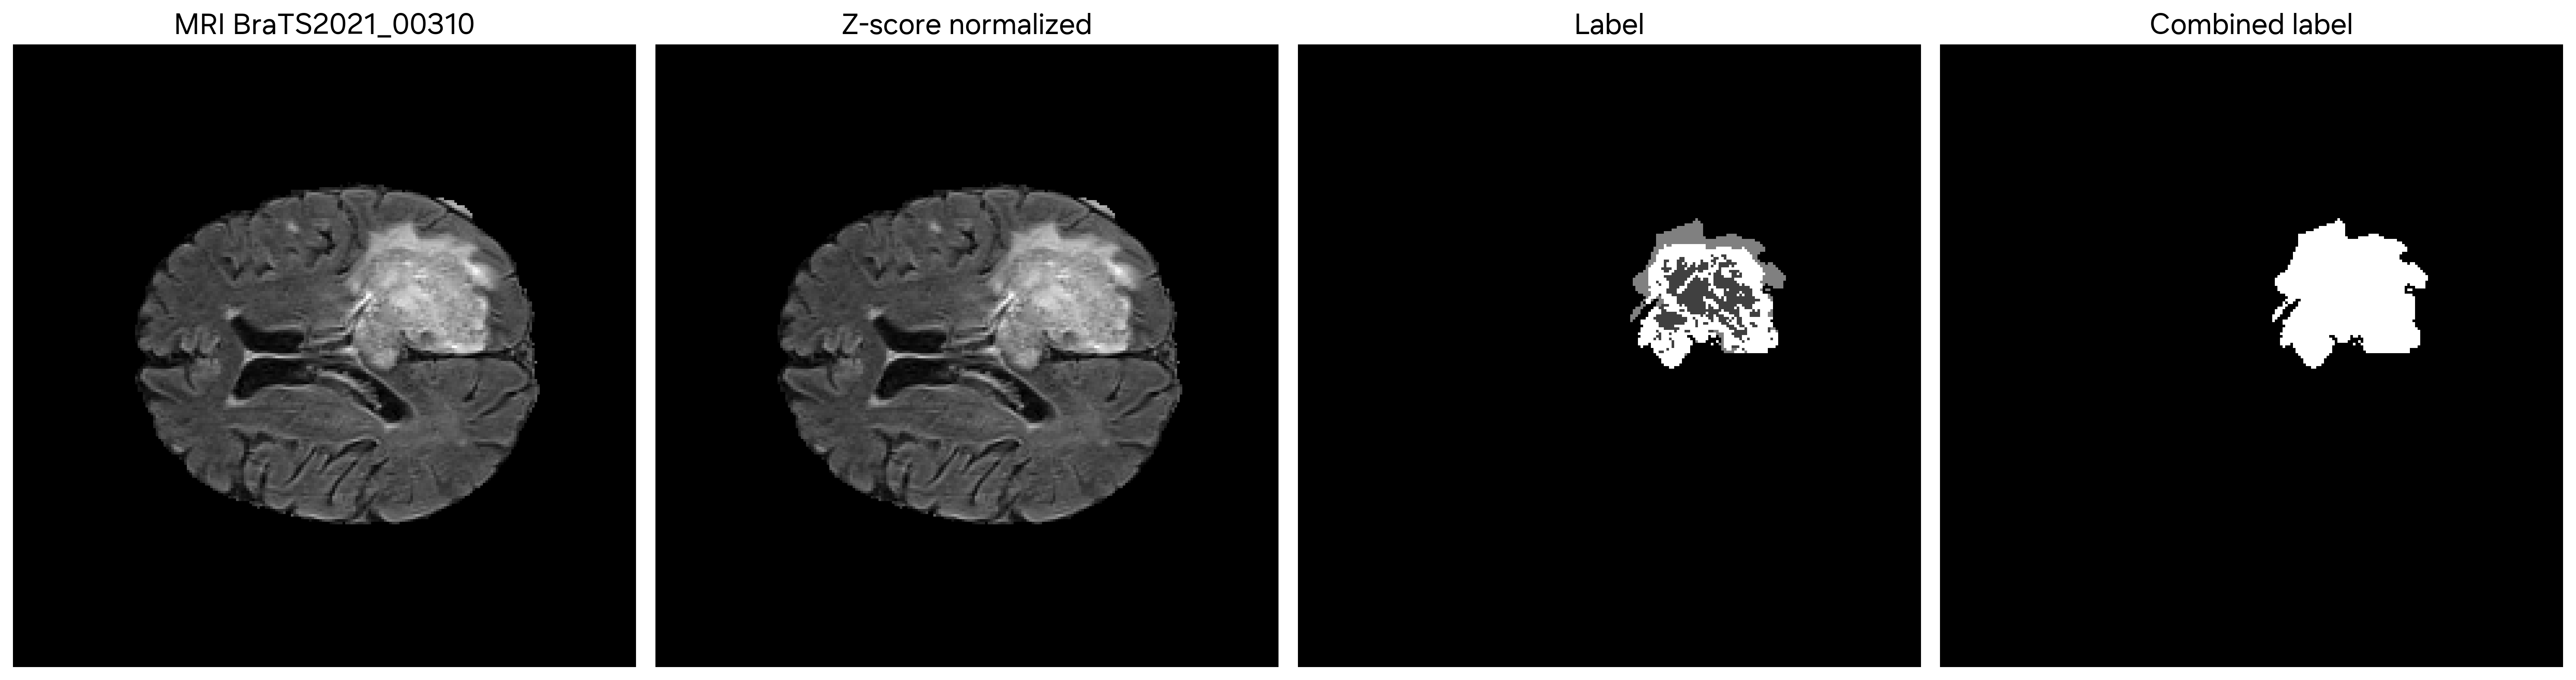

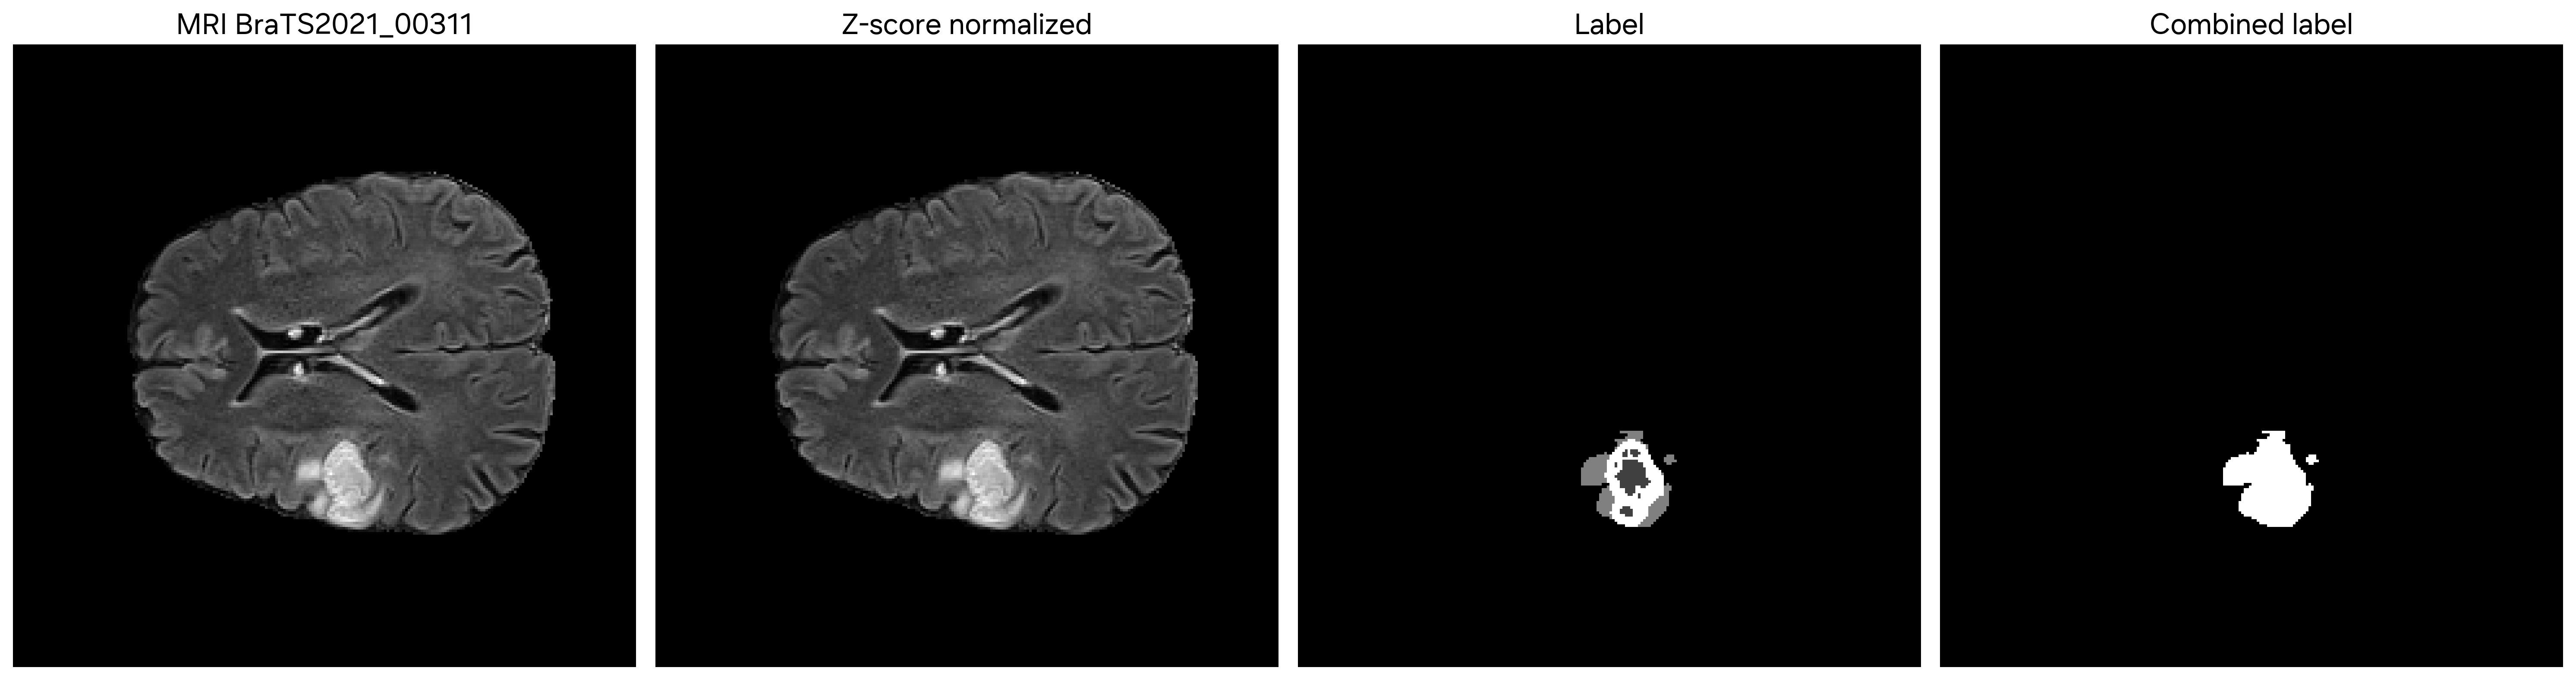

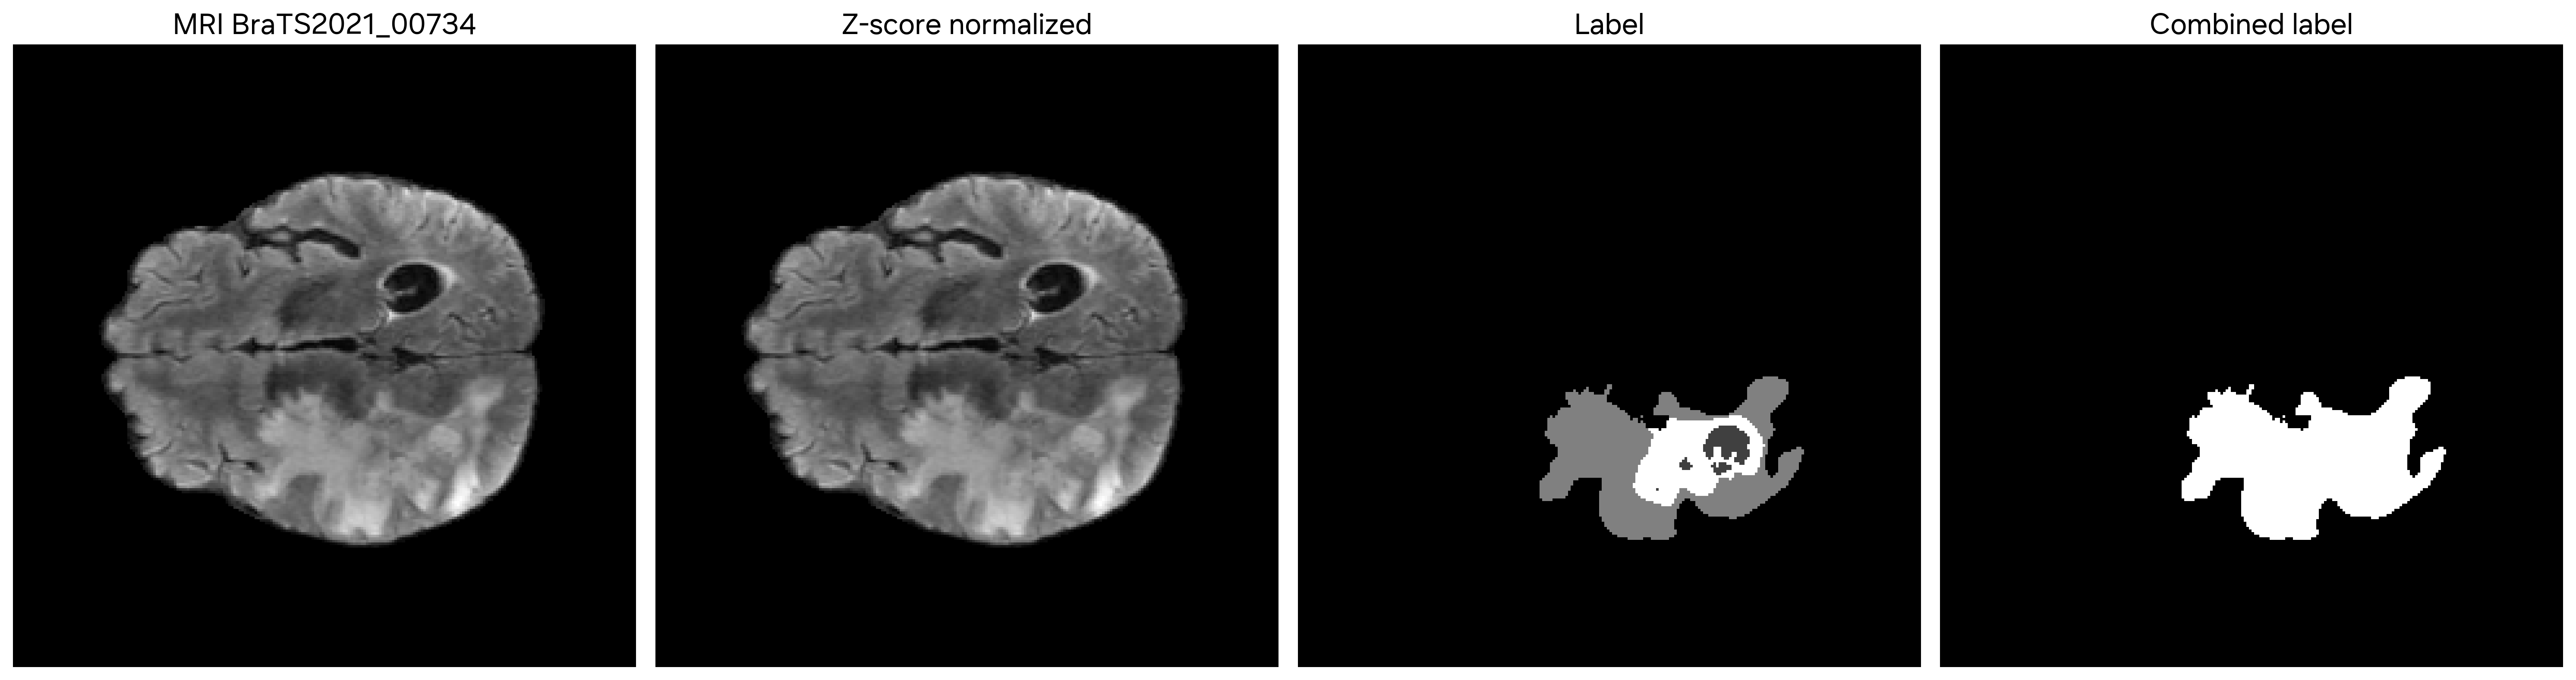

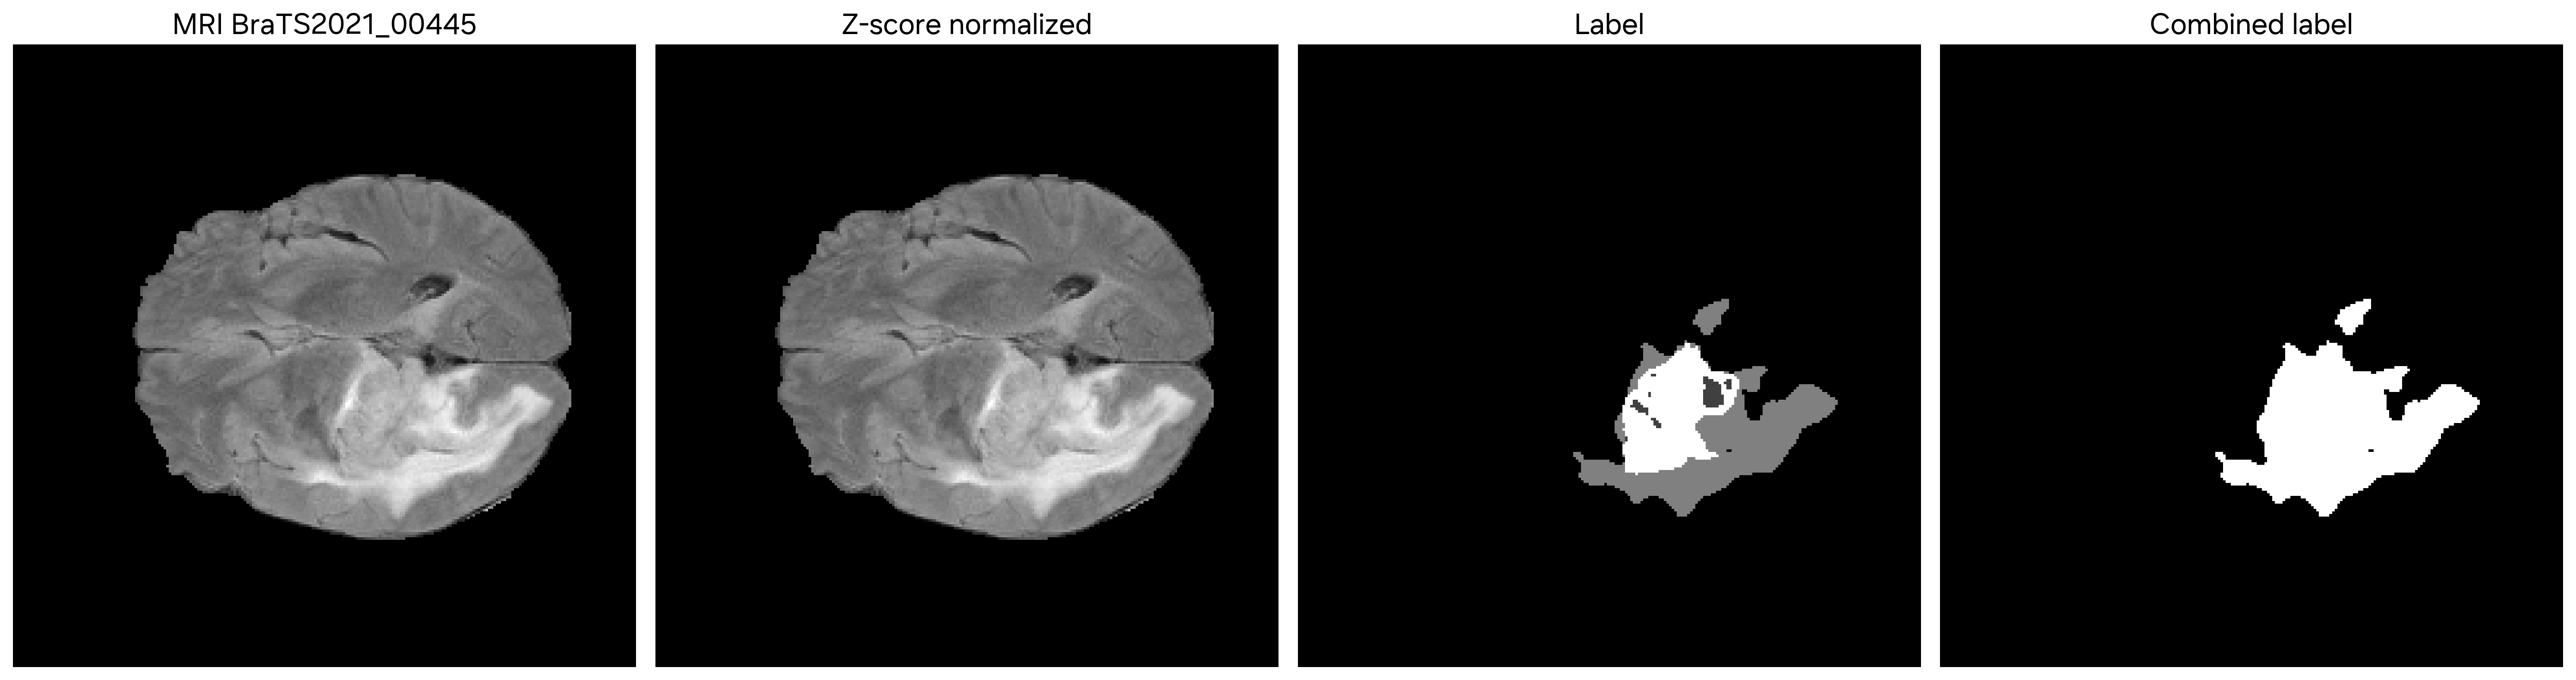

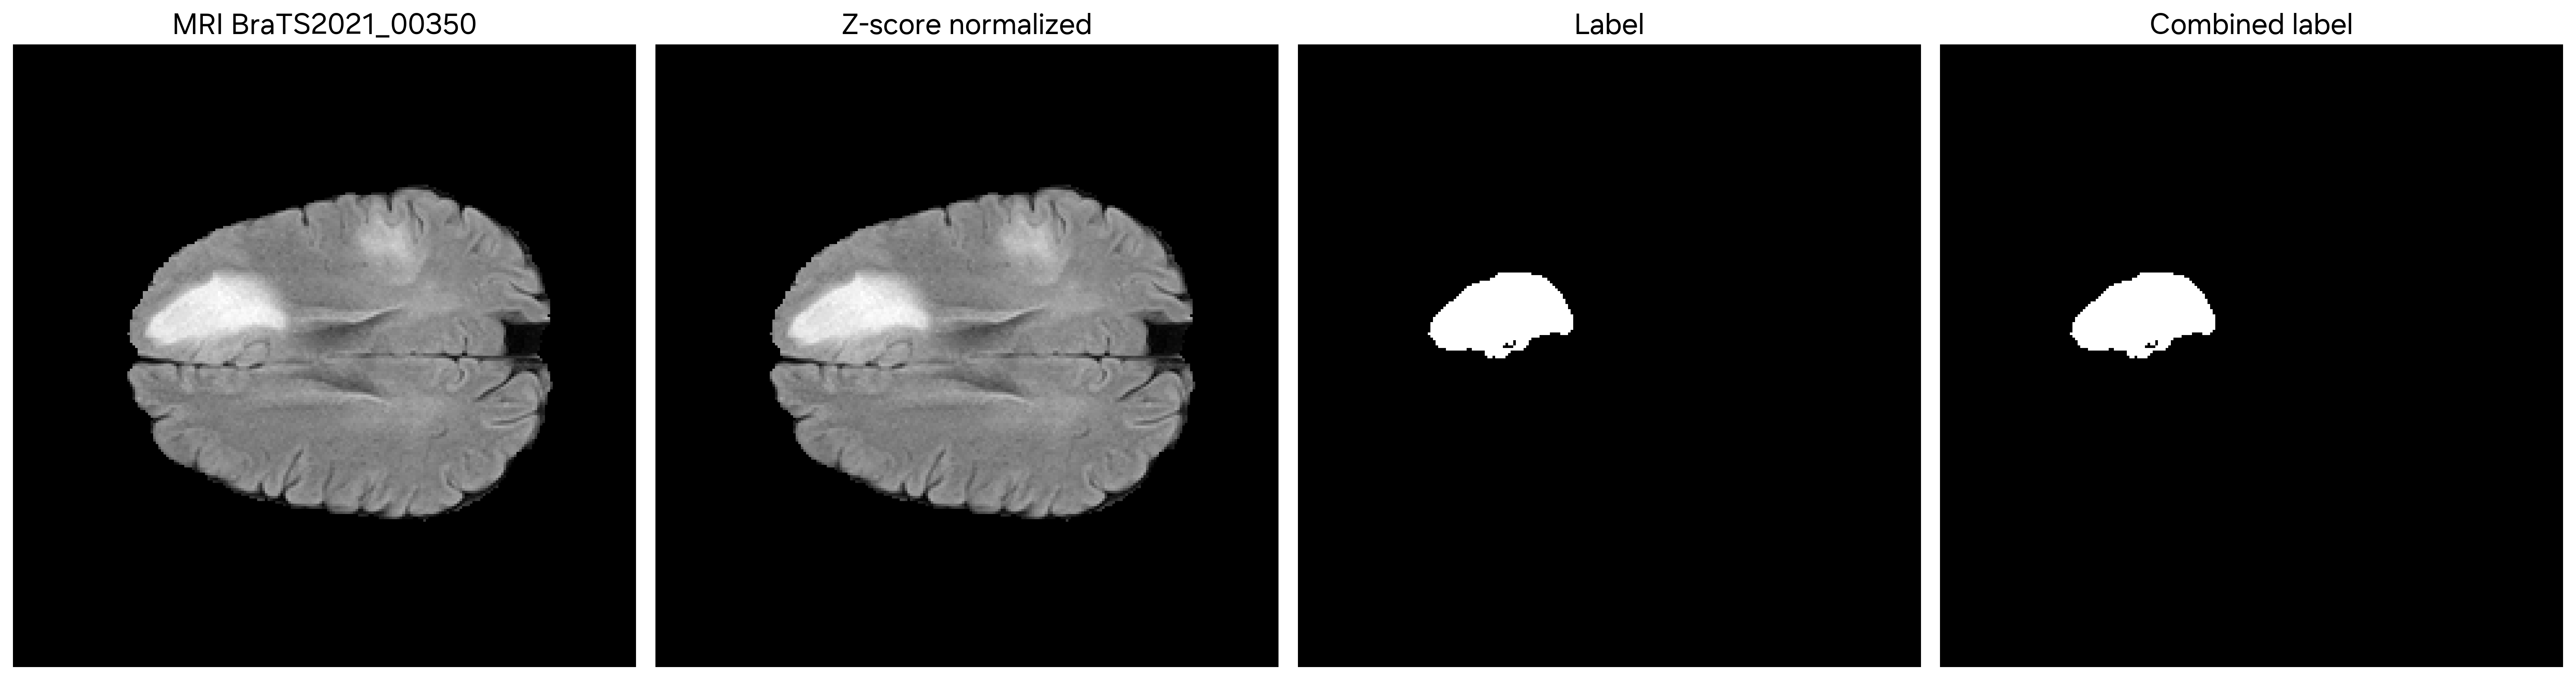

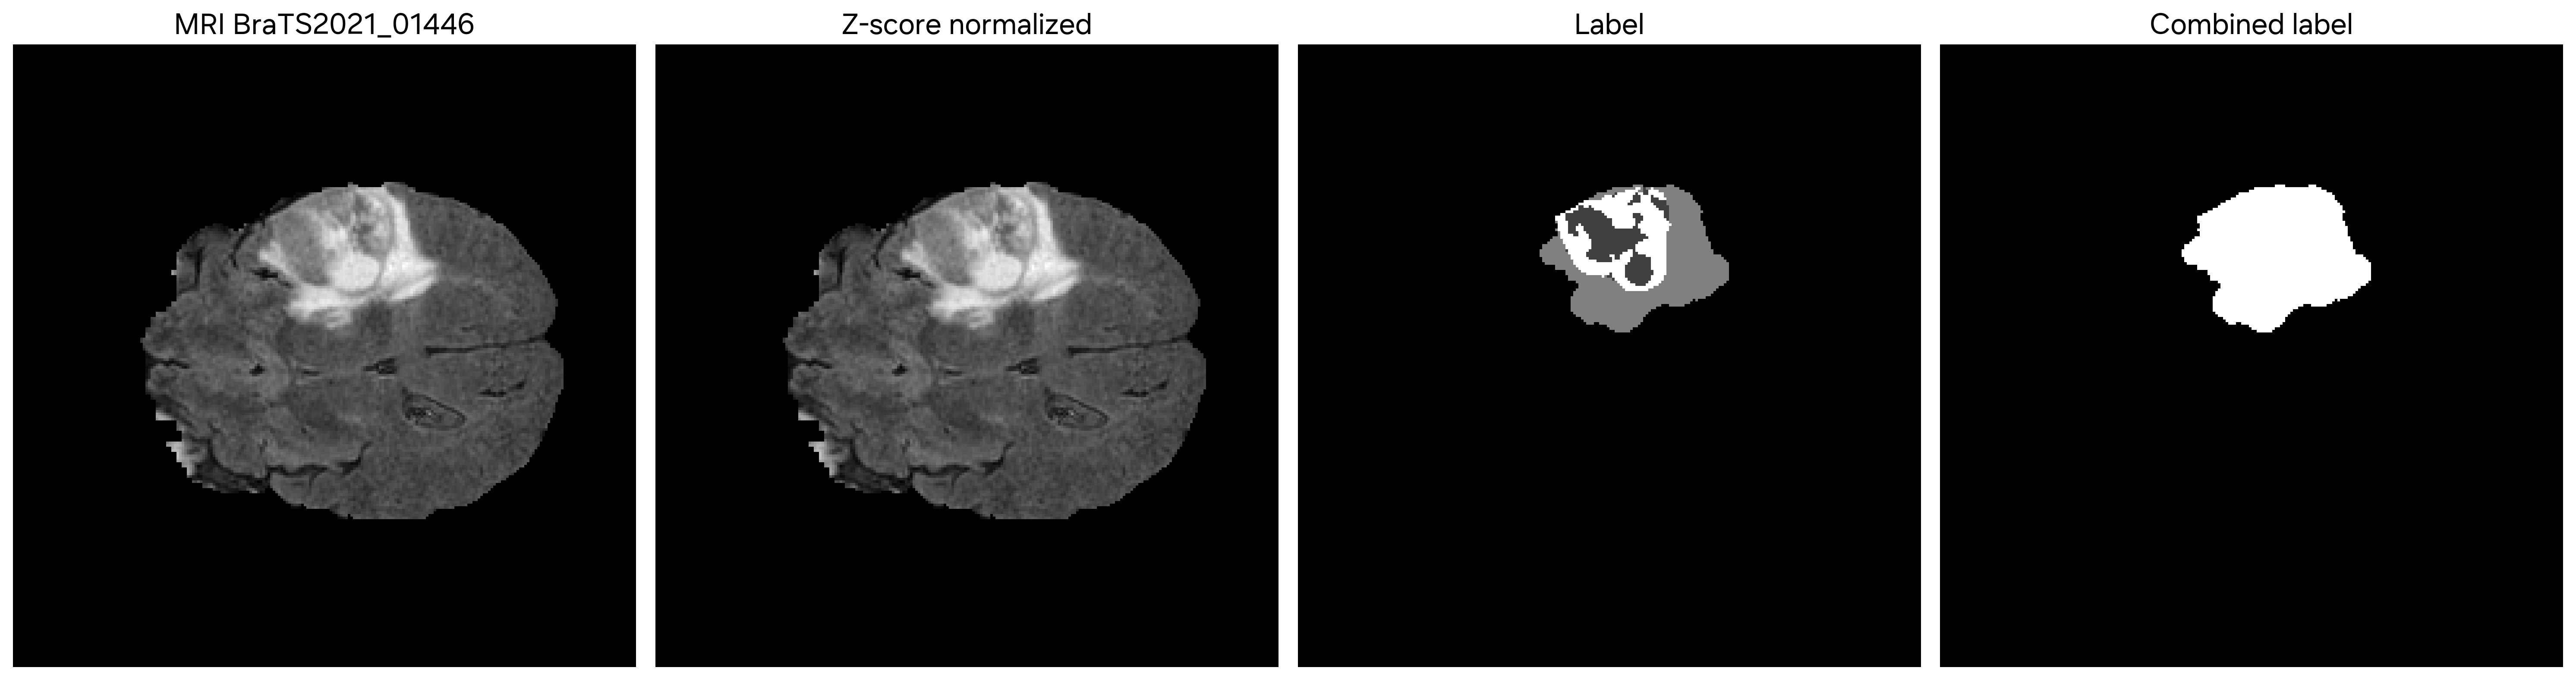

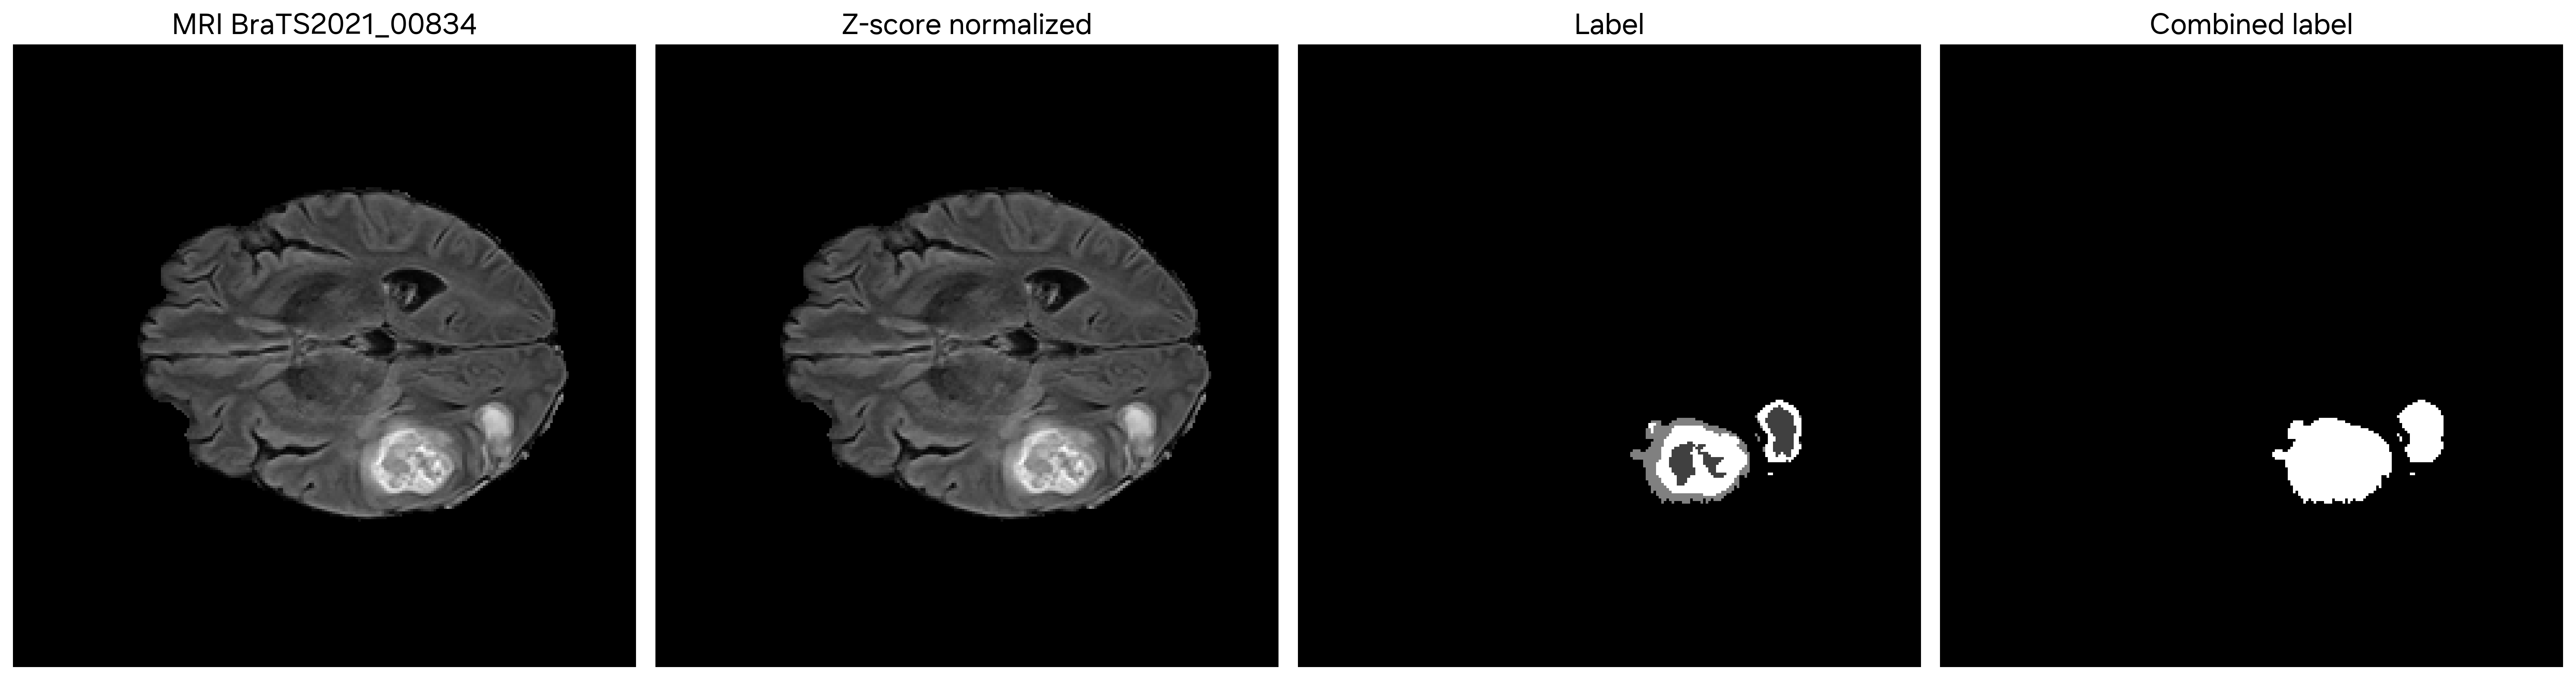

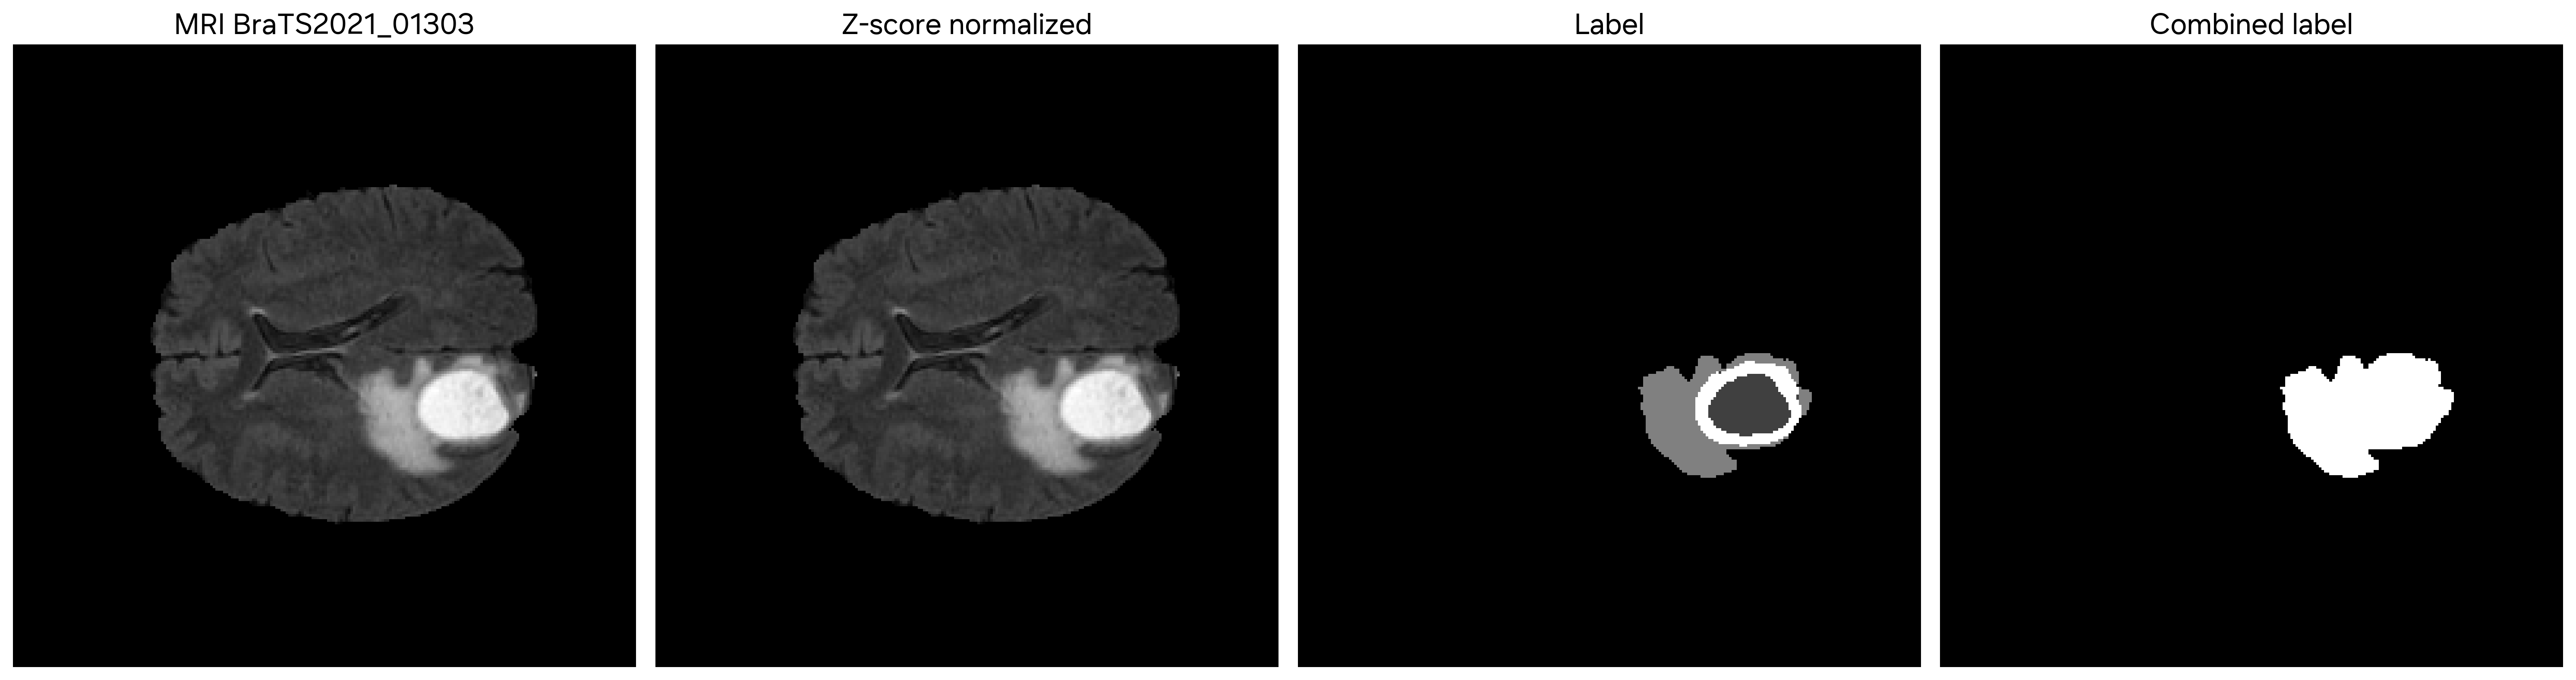

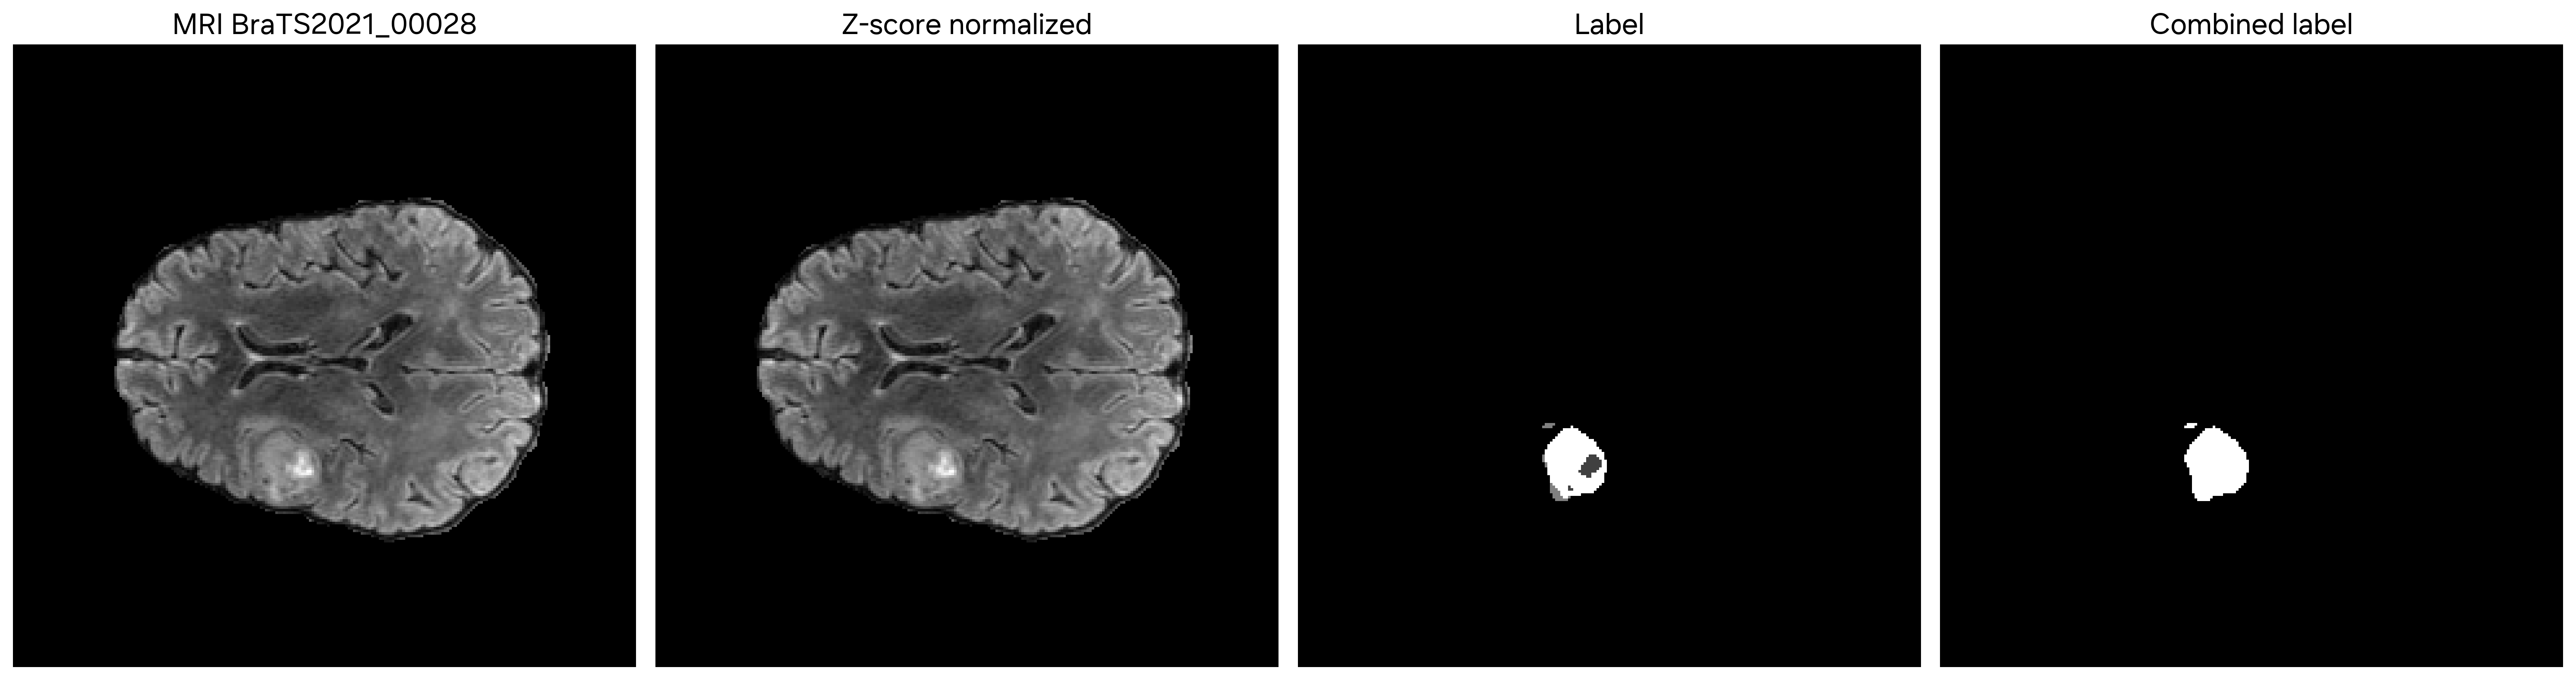

In [13]:
for _ in range(10):
    plot_largest_tumor_area(get_random_image_path(os.path.join(training_data_path, 'imagesTr')))

In [14]:
def plot_tumor_presence_fraction(data_path):
    total_slices = 0
    slices_with_tumor = 0

    for root, _, files in os.walk(os.path.join(data_path, 'labelsTr')):
        for file in files:
            if file.endswith(".nii.gz"):
                label_img = nib.load(os.path.join(root, file))
                label_data = label_img.get_fdata()

                total_slices += label_data.shape[-1]
                slices_with_tumor += np.sum(np.any(label_data != 0, axis=(0, 1)))

    slices_without_tumor = total_slices - slices_with_tumor
    fractions = [slices_without_tumor / total_slices, slices_with_tumor / total_slices]

    plt.figure(figsize=(8, 6))
    plt.pie(fractions, labels=['Without Tumor', 'With Tumor'], colors=['forestgreen', 'peru'], startangle=90)
    plt.title('Fraction of Slices Without Tumor vs With Tumor')
    plt.show()

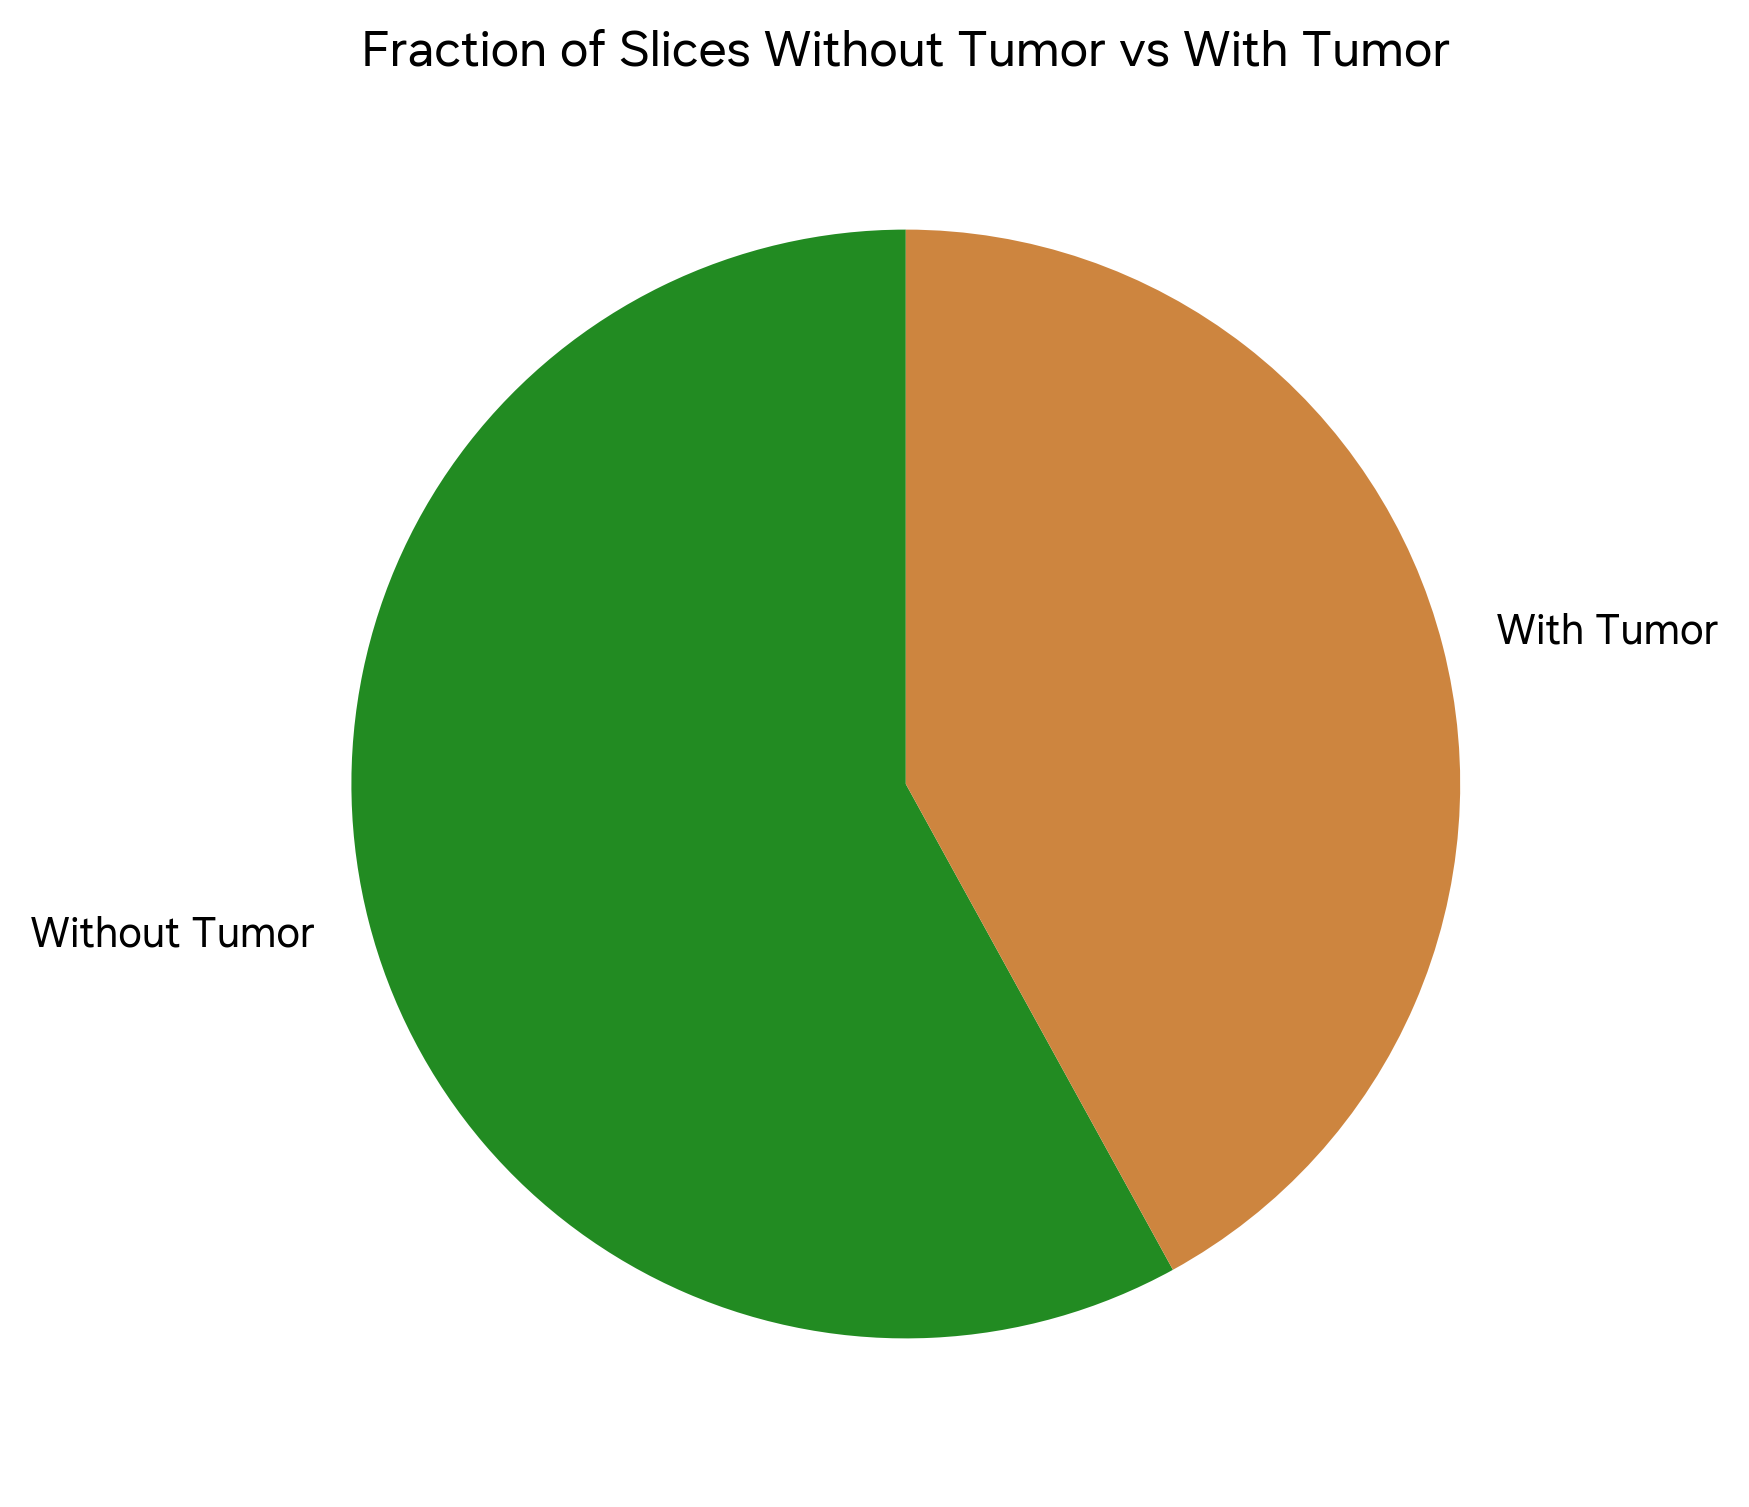

In [15]:
plot_tumor_presence_fraction(training_data_path)

In [16]:
def visualize_flip_and_rotate(image_path):
    if not image_path.endswith(".nii.gz"):
        print("Invalid image path.")
        return

    img = nib.load(image_path)
    data = img.get_fdata()

    slice_index = np.argmax([np.sum(data[..., i]) for i in range(data.shape[-1])])
    file_name = os.path.basename(image_path).split('.')[0]

    plt.figure(figsize=(20, 10))

    def plot_subplot(data, index, title, subplot_index):
        plt.subplot(1, 3, subplot_index)
        plt.imshow(data[..., index], cmap="gray")
        plt.axis("off")
        plt.title(title, fontsize=16)

    plot_subplot(data, slice_index, f"MRI {file_name}", 1)

    flipped_data = np.flip(data, np.random.choice([0, 1]))
    plot_subplot(flipped_data, slice_index, "Flipped", 2)

    rotated_data = np.rot90(data, np.random.choice([1, 2, 3]), axes=(0, 1))
    plot_subplot(rotated_data, slice_index, "Rotated", 3)

    plt.tight_layout()
    plt.show()

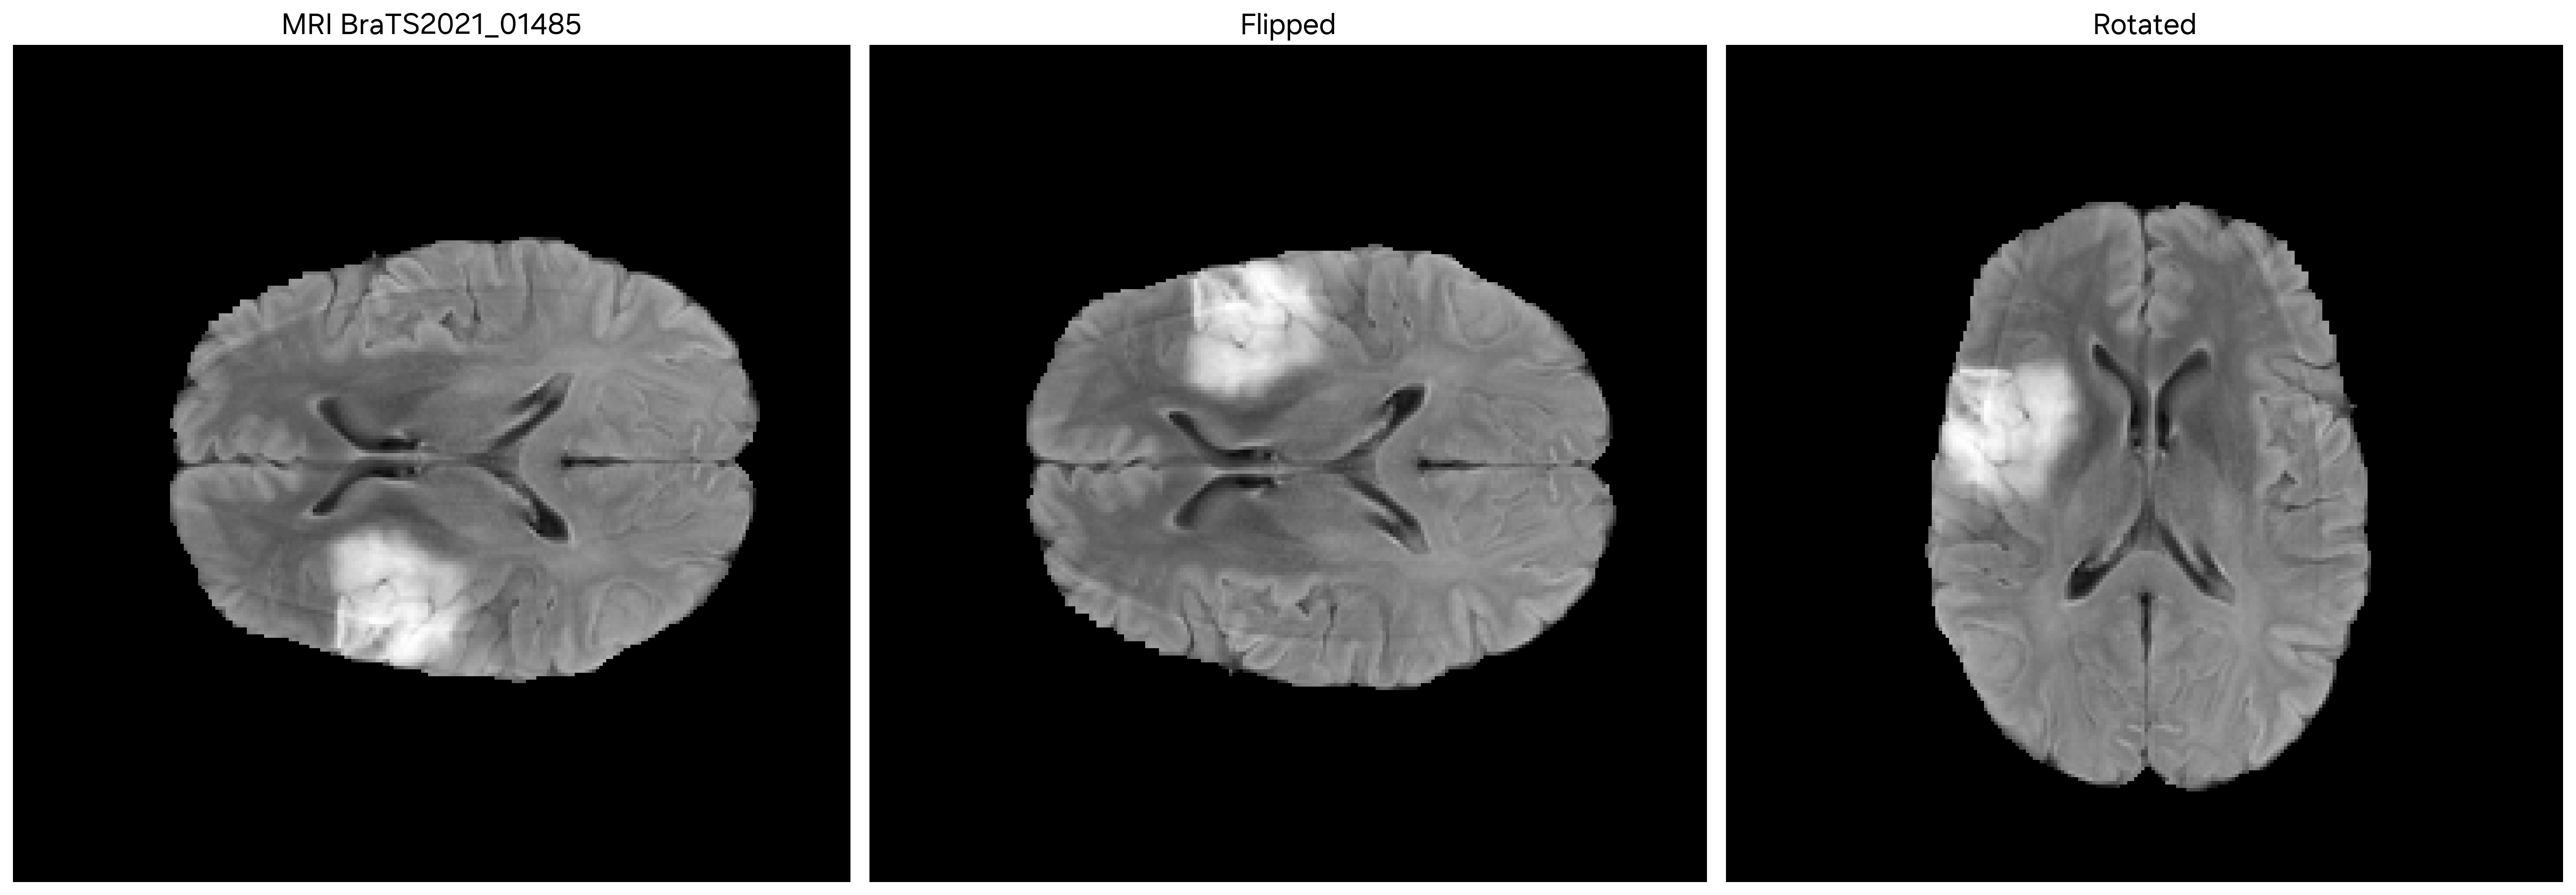

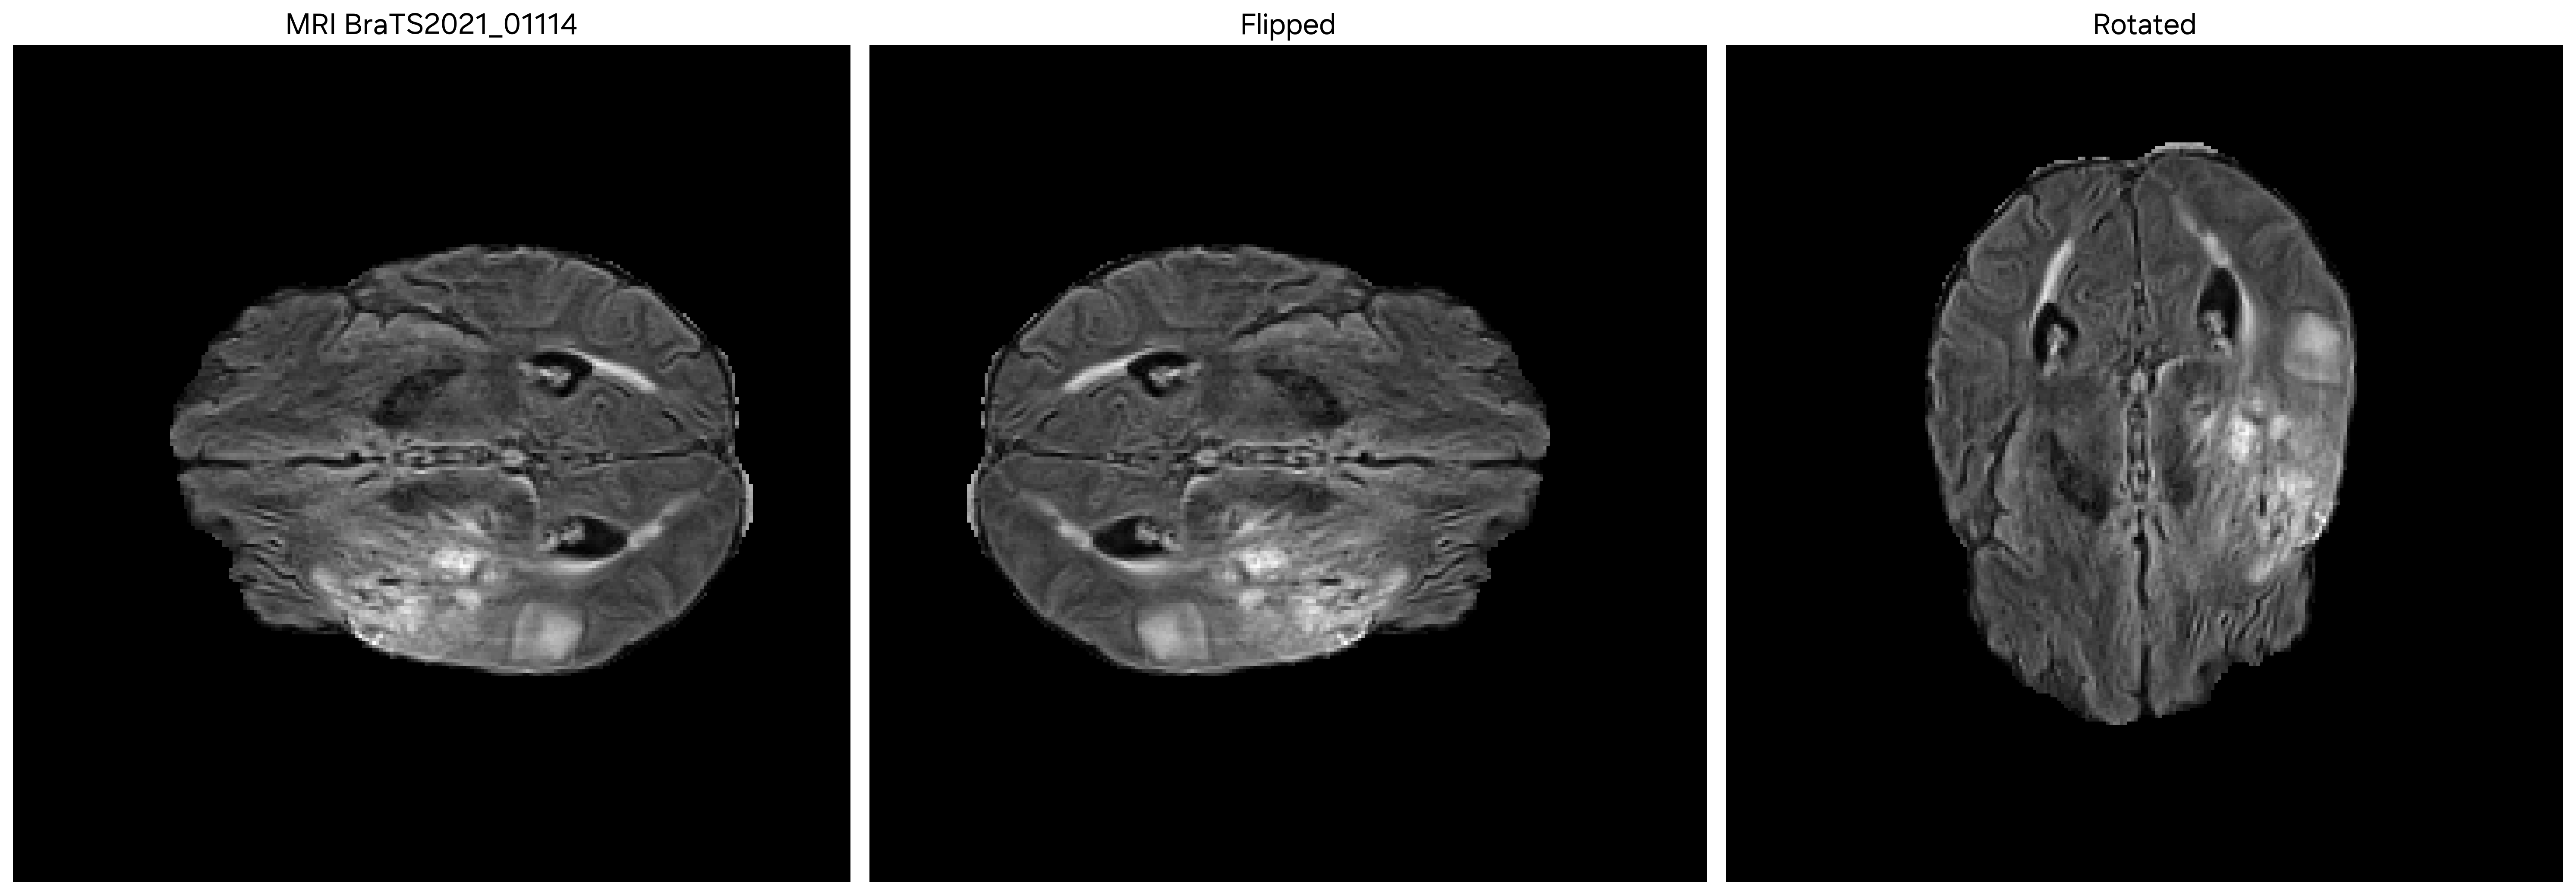

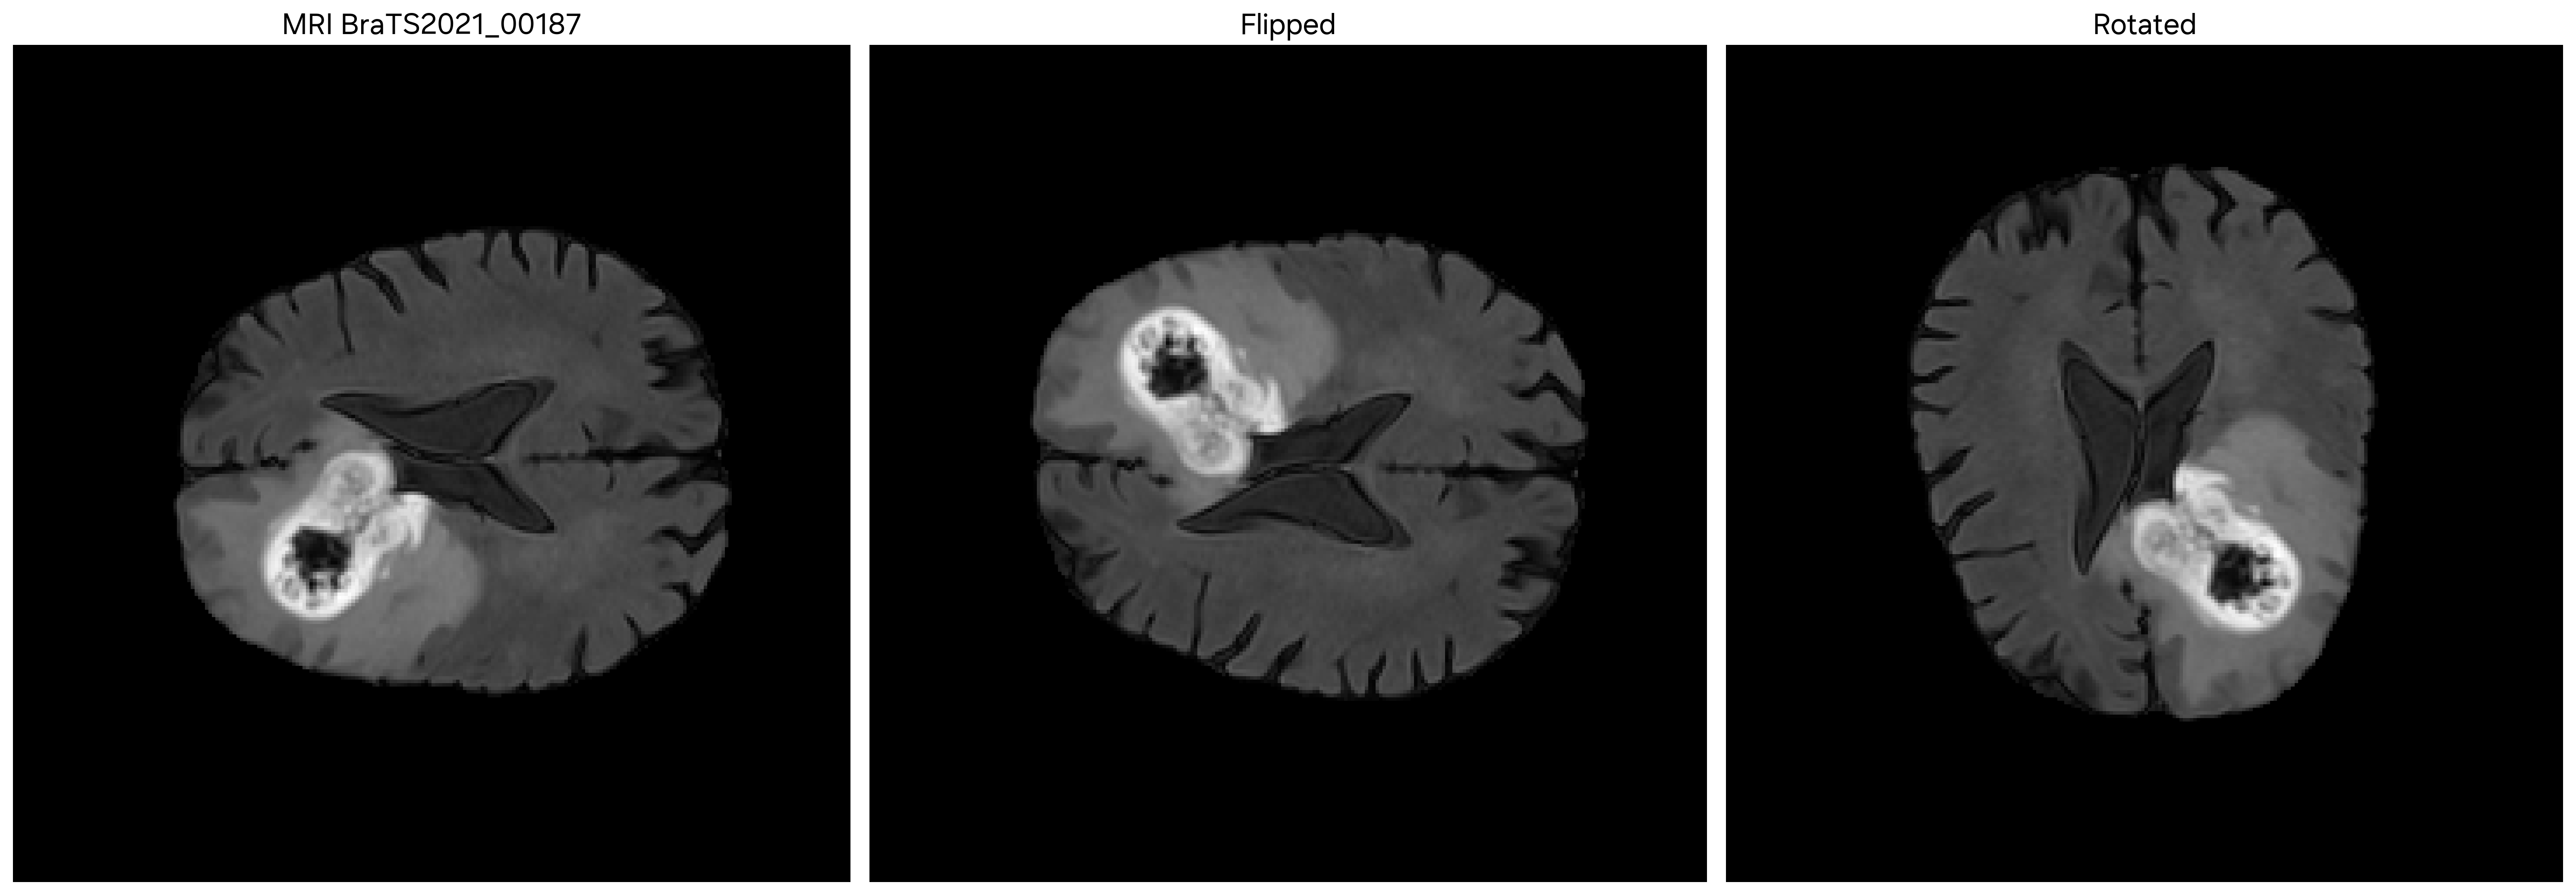

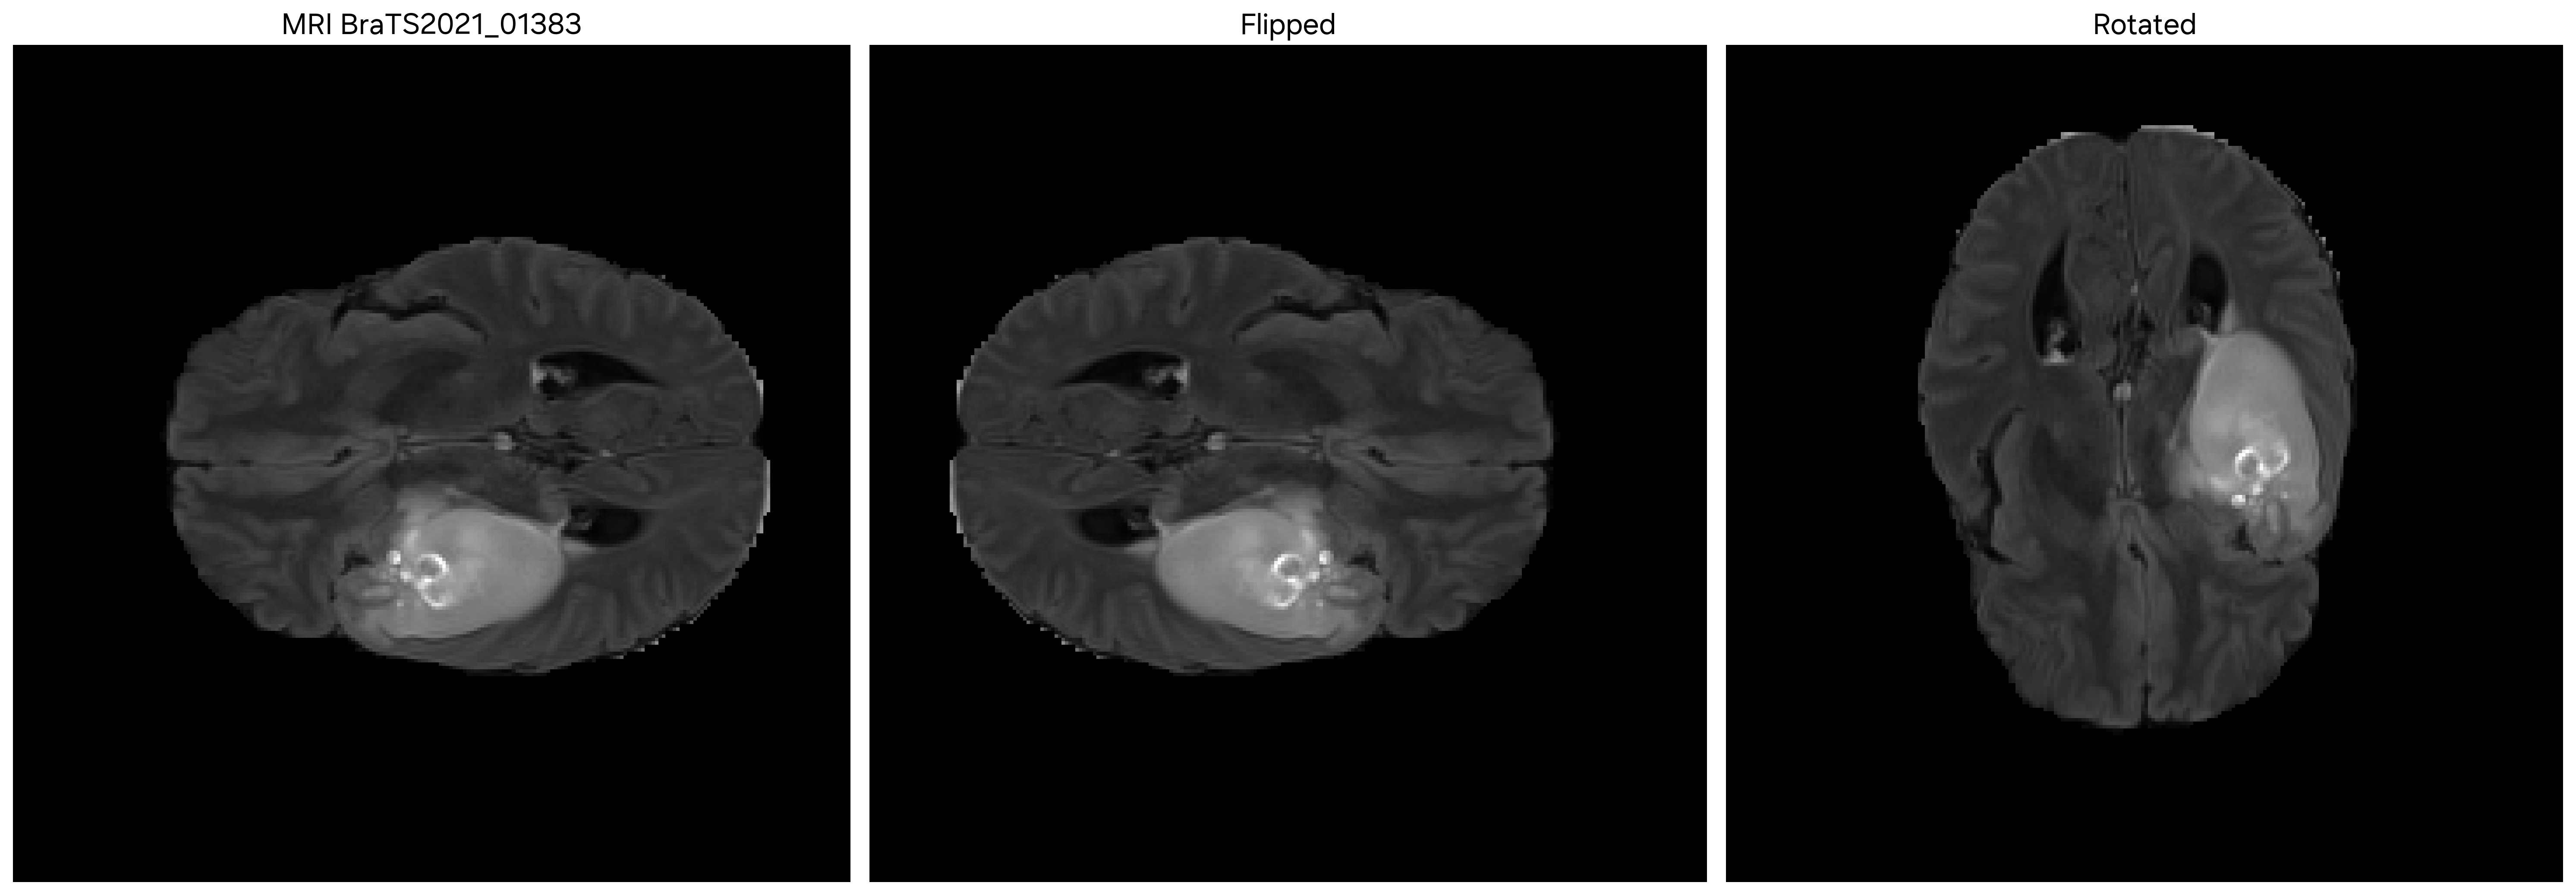

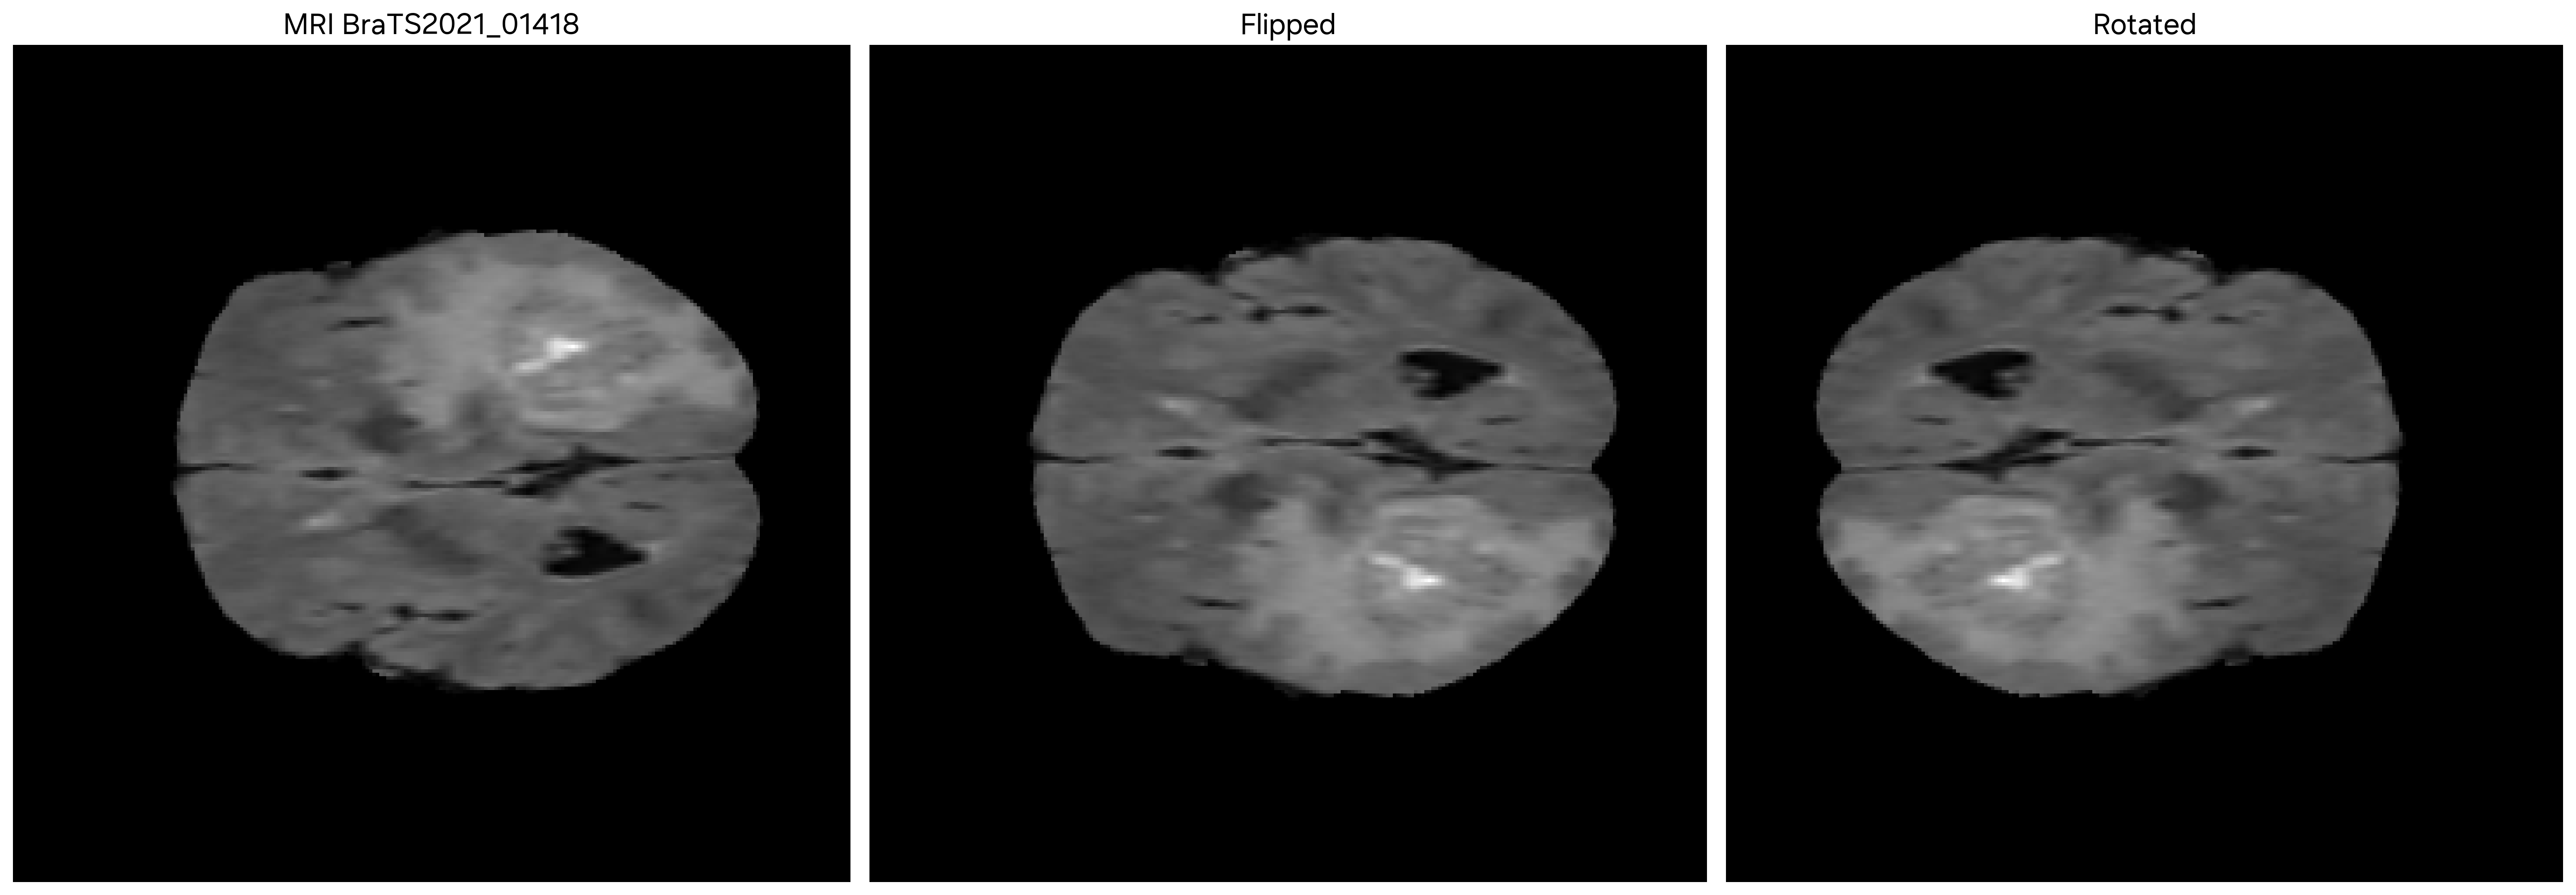

In [17]:
for _ in range(5):
    visualize_flip_and_rotate(get_random_image_path(os.path.join(training_data_path, 'imagesTr')))